# Goal:
Predict the apple stock price in next day by using linear regression

Given prices for the last N days, we train a model, and predict for day N+1



In [295]:
# Import Dependencies
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
%matplotlib inline


In [296]:
# Load the file
apple_data = pd.read_csv('resources/apple.csv')
apple_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj_Close,Volume,Year,Quarter
0,0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900,2017,1
1,1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100,2017,1
2,2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600,2017,1
3,3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900,2017,1
4,4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900,2017,1


In [297]:
# Drop the columns
apple = apple_data.drop(columns=['Unnamed: 0', 'Year', 'Quarter'])
apple.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2017-01-03,115.800003,116.330002,114.760002,116.150002,110.953873,28781900
1,2017-01-04,115.849998,116.510002,115.750000,116.019997,110.829704,21118100
2,2017-01-05,115.919998,116.860001,115.809998,116.610001,111.393303,22193600
3,2017-01-06,116.779999,118.160004,116.470001,117.910004,112.635139,31751900
4,2017-01-09,117.949997,119.430000,117.940002,118.989998,113.666824,33561900


In [298]:
apple['Date'] = pd.to_datetime(apple.Date,format='%Y-%m-%d')


There are multiple variables in the dataset – date, open, high, low, close, Adj_close & volume.

The columns open and close represent the starting and final price at which the stock is traded on a particular day. High and low represent the maximum, minimum, and last price of the share for the day. Volume is the number of shares bought or sold on that day.
Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions.
We will consider the adjusted closing price as the target variable. 

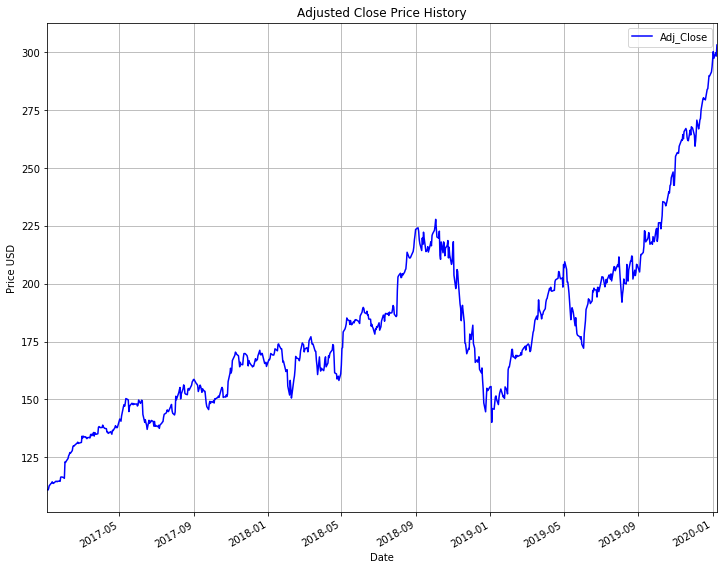

In [299]:
# Plot the adj closing data 
rcParams['figure.figsize'] = 12, 10
ax = apple.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_title("Adjusted Close Price History")
plt.savefig("./images/Aj_close history.png")

# Split dataset into train, validation and test set

In [300]:
# Input paramaters
test_size = 0.2                 # proportion of dataset for test set
cv_size = 0.2                   # proportion of dataset for cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N to test
fontsize = 14
ticklabelsize = 14

In [308]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(apple))
num_test = int(test_size*len(apple))
num_train = len(apple) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 457
num_cv = 151
num_test = 151


In [309]:
# Split into train, cv, and test
train = apple[:num_train].copy()
cv = apple[num_train:num_train+num_cv].copy()
train_cv = apple[:num_train+num_cv].copy()
test = apple[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (457, 7)
cv.shape = (151, 7)
train_cv.shape = (608, 7)
test.shape = (151, 7)


In [310]:
cv.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume
603,2019-05-29,176.419998,179.350006,176.000000,177.380005,176.179657,28481200
604,2019-05-30,177.949997,179.229996,176.669998,178.300003,177.093445,21218400
605,2019-05-31,176.229996,177.990005,174.990005,175.070007,173.885300,27043600
606,2019-06-03,175.600006,177.919998,170.270004,173.300003,172.127274,40396100
607,2019-06-04,175.440002,179.830002,174.520004,179.639999,178.424377,30968000


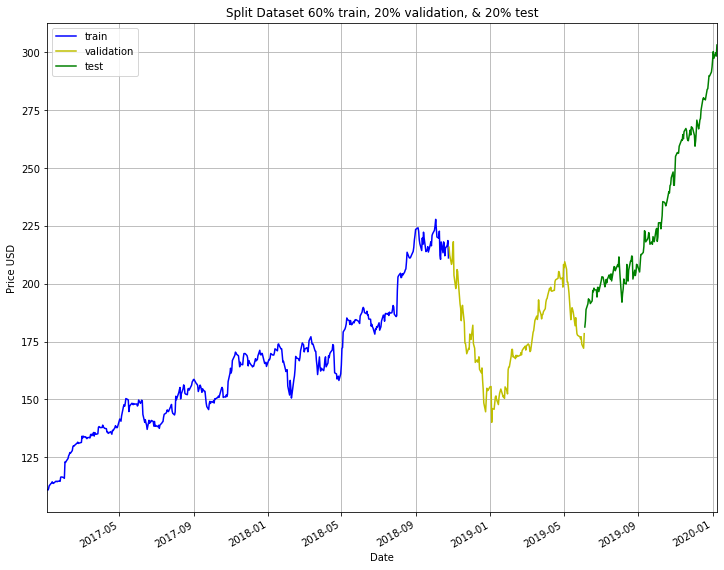

In [311]:
# Plot the data accordingly
rcParams['figure.figsize'] = 12, 10
ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_title("Split Dataset 60% train, 20% validation, & 20% test")
plt.savefig("./images/Slpit.png")

# Prediction by Linear Regression

The most basic machine learning algorithm that can be implemented on this data is linear regression. 

In [312]:
def predict_lin_reg(apple, target_col, N, pred_min, offset):  # apple => dataframe with the values we want to predict
                                                              # target_col => 'Adj_Close' we want to predict
        
    regr = LinearRegression(fit_intercept=True)     # N => get prediction at timestep t using values from t-1, t-2, ..., t-N
                                                              # pred_min => predictions should be >= pred_min
    pred_list = []                                            # offset => offset can be size of training set
                                                    # pred_list  : the predictions for target_col. np.array of length len(apple)-offset
    for i in range(offset, len(apple['Adj_Close'])):
        X_train = np.array(range(len(apple['Adj_Close'][i-N:i])))
        y_train = np.array(apple['Adj_Close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
        y_train = y_train.reshape(-1, 1)
    # Train the model
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [313]:
RMSE = []
R2 = []
MAPE = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = predict_lin_reg(train_cv, 'Adj_Close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['Adj_Close'])))
    R2.append(r2_score(cv['Adj_Close'], est_list))
    MAPE.append(get_mape(cv['Adj_Close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(MAPE))
cv.head()   

RMSE = [3.905844315921211, 5.596721327964514, 5.019769206295928, 4.978407638862982, 4.975430954803471, 4.927458913058318, 4.885796112664123, 4.774656725135466, 4.720793969367129, 4.726949101484141, 4.800000942074946, 4.85372303056591, 4.855911214335038, 4.867761241314721, 4.905053135567641, 5.017137184788405, 5.17168529324248, 5.296857848490742, 5.404598900164277, 5.50377288938014, 5.614150084488982, 5.724206007828147, 5.839341458931085, 5.950108670658729, 6.090340242855644, 6.248246388453958, 6.402119491635694, 6.5721530415423555, 6.7210360381116745, 6.869625398367043]
R2 = [0.9546597568674318, 0.9069060723883529, 0.9251104040398958, 0.9263394603756515, 0.9264275201003361, 0.9278394207547033, 0.9290545305749923, 0.932245476695471, 0.9337655276266658, 0.933592697502918, 0.9315242760281854, 0.9299829243052571, 0.9299197790605873, 0.9295773239532514, 0.9284941752568734, 0.9251889173513368, 0.9205089623540113, 0.9166144834786821, 0.9131877675891694, 0.9099725401333904, 0.906325361777494, 

,Date,Open,High,Low,Close,Adj_Close,Volume,est_N1,est_N2,est_N3,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
457,2018-10-25,217.710007,221.380005,216.750000,219.800003,215.793457,29855800,211.169296,203.668563,210.030441,...,213.231951,213.712723,214.248801,214.962671,215.374323,215.851262,216.264190,216.639170,216.553083,216.317439
458,2018-10-26,215.899994,220.190002,212.669998,216.300003,212.357239,47258400,215.793457,220.417618,212.334355,...,212.537606,213.234206,213.673825,214.172489,214.847507,215.238214,215.695100,216.093587,216.457955,216.378626
459,2018-10-29,219.190002,219.690002,206.089996,212.240005,208.371262,45935500,212.357239,208.921021,214.294607,...,211.684539,211.980851,212.648590,213.076247,213.563741,214.223968,214.614393,215.070206,215.471394,215.840795
460,2018-10-30,211.149994,215.179993,209.270004,213.300003,209.411926,36660000,208.371262,204.385285,204.751791,...,210.278503,210.517376,210.826997,211.493070,211.932136,212.429835,213.095195,213.502643,213.973492,214.392107
461,2018-10-31,216.880005,220.449997,216.619995,218.860001,214.870590,38358900,209.411926,210.452590,207.101496,...,209.423472,209.485749,209.721087,210.025818,210.674681,211.109667,211.603293,212.260858,212.672401,213.146363


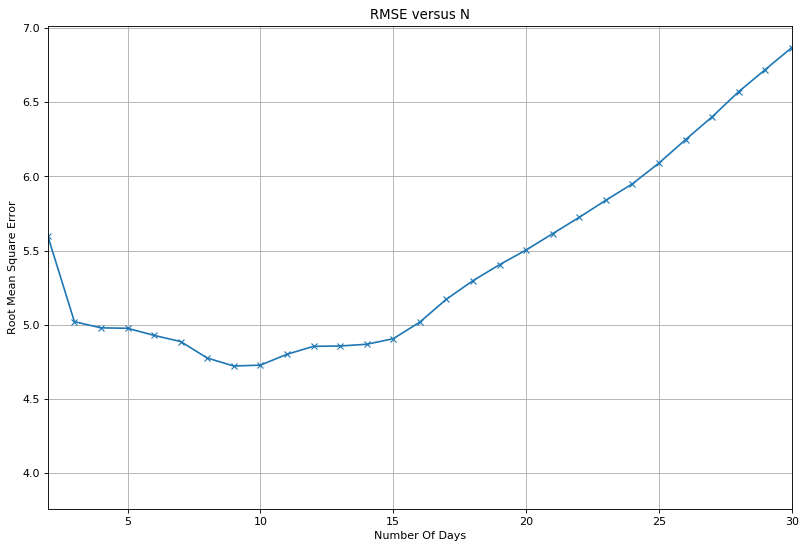

In [325]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('Number Of Days')
plt.ylabel('Root Mean Square Error')
plt.xlim([2, 30])
plt.title("RMSE versus N")
plt.savefig("./images/RMSE vs N.png")

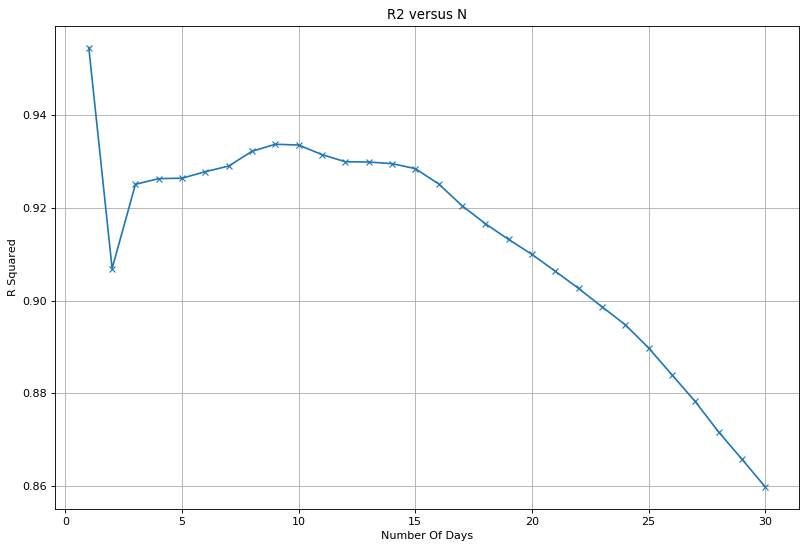

In [326]:
# Plot R2 versus N (R2 larger better)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, '-x')
plt.grid()
plt.xlabel('Number Of Days')
plt.ylabel('R Squared')
plt.title("R2 versus N")
plt.savefig("./images/R2 vs N.png")

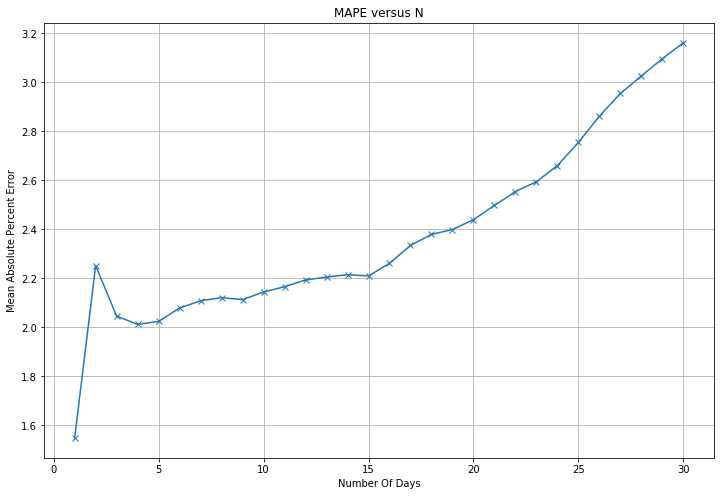

In [327]:
# Plot MAPE versus N. (MAPE smaller better) 
plt.figure(figsize=(12, 8))
plt.plot(range(1, Nmax+1), MAPE, 'x-')
plt.grid()
plt.xlabel('Number Of Days')
plt.ylabel('Mean Absolute Percent Error')
plt.title("MAPE versus N")
plt.savefig("./images/MAPE vs N.png")

In [317]:
# Set optimum N
N_opt = 5

# Predictions for a specific day by plot

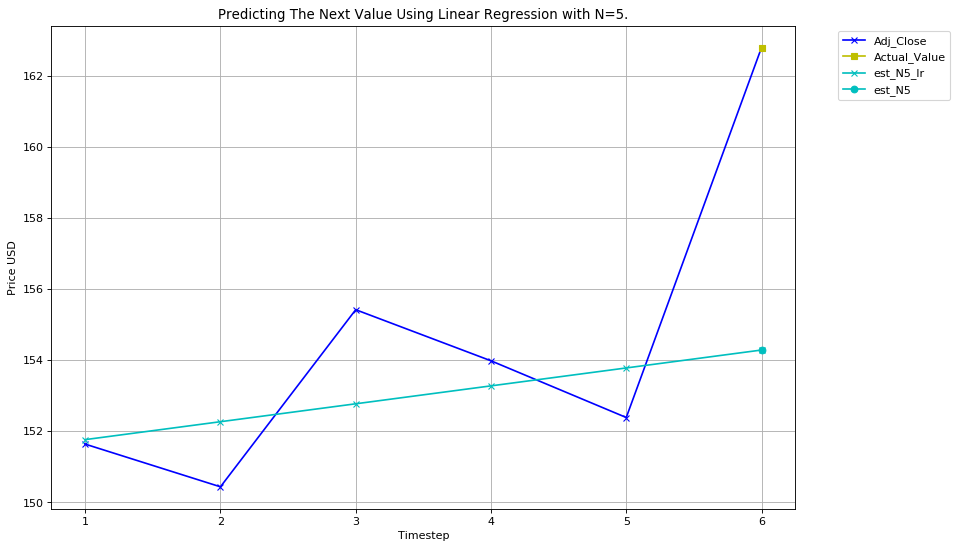

In [318]:
# Specify the day you are interested in
day = pd.Timestamp(date(2019, 1, 30))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

apple_temp = cv[cv['Date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), apple_temp[-Nmax2-1:]['Adj_Close'], 'bx-')
plt.plot(Nmax2+1, apple_temp[-1:]['Adj_Close'], 'ys-')
legend_list = ['Adj_Close', 'Actual_Value']
# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
# Create linear regression object
regr = LinearRegression(fit_intercept=True) 
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(apple_temp['Adj_Close'][-N-1:-1]))) 
    y_train = np.array(apple_temp['Adj_Close'][-N-1:-1]) 
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
     # Train the model
    regr.fit(X_train, y_train)            
    # Get linear regression line
    y_est = regr.predict(X_train)       
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(apple_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             apple_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('Timestep')
plt.ylabel('Price USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
plt.title("Predicting The Next Value Using Linear Regression with N=5.")

plt.savefig("./images/Nextday.png")


# Plot predictions on validation set

Text(0, 0.5, 'Price USD')

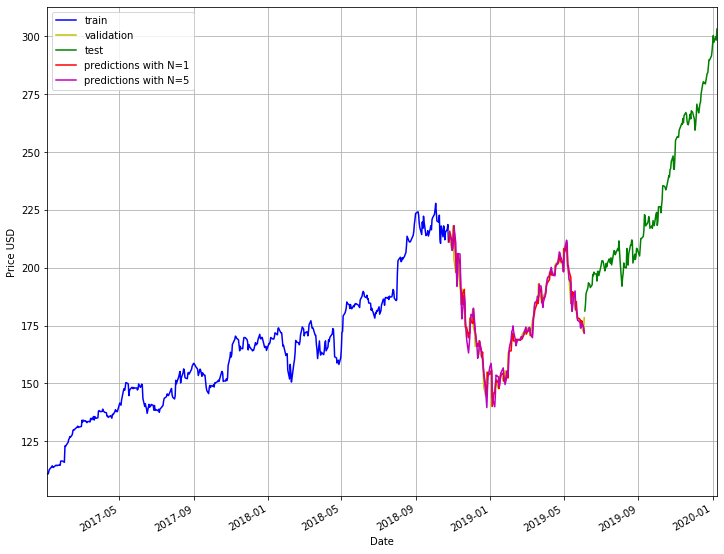

In [319]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 12, 10
ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")


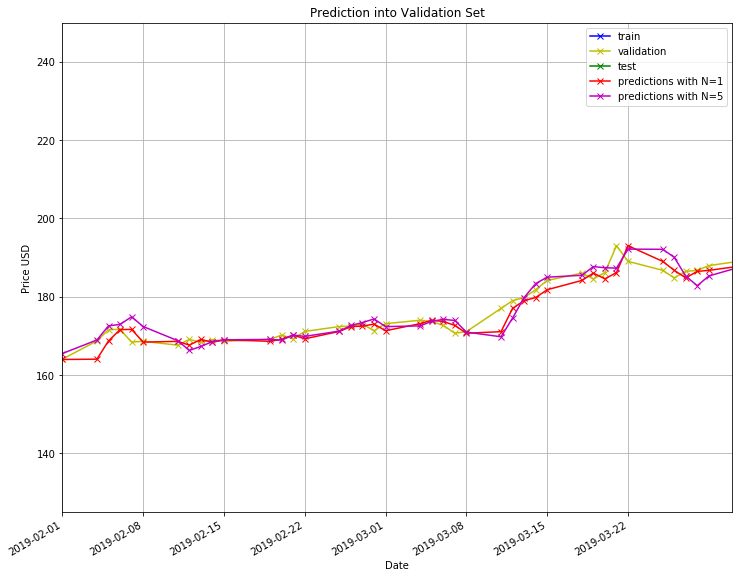

In [320]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 12, 10 

ax = train.plot(x='Date', y='Adj_Close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_xlim([date(2019, 2, 1), date(2019, 3, 31)])
ax.set_ylim([125, 250])
ax.set_title('Prediction into Validation Set')
plt.savefig("./images/ 2months.png")

# Final Model withTest set

In [321]:
est_list = predict_lin_reg(apple, 'Adj_Close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['Adj_Close'])))
print("R2 = %0.3f" % r2_score(test['Adj_Close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['Adj_Close'], est_list))
test.head()

RMSE = 3.953
R2 = 0.985
MAPE = 1.370%


,Date,Open,High,Low,Close,Adj_Close,Volume,est_N5
608,2019-06-05,184.279999,184.990005,181.139999,182.539993,181.304733,29773400,175.398991
609,2019-06-06,183.080002,185.470001,182.149994,185.220001,183.966614,22526300,180.455522
610,2019-06-07,186.509995,191.919998,185.770004,190.149994,188.863251,30684400,186.743686
611,2019-06-10,191.809998,195.369995,191.619995,192.580002,191.276810,26220900,192.641507
612,2019-06-11,194.860001,196.000000,193.600006,194.809998,193.491714,26932900,194.746172


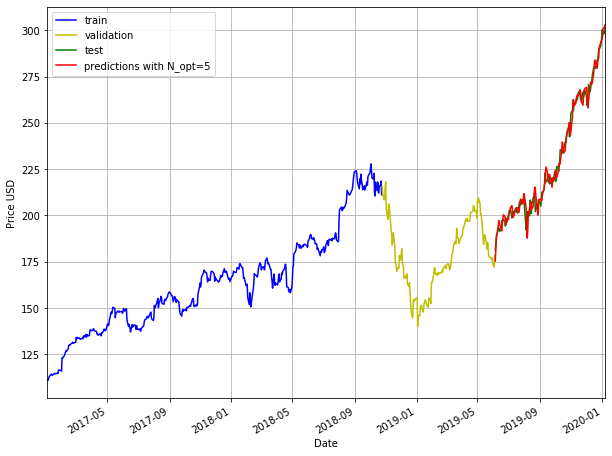

In [322]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='Date', y='Adj_Close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='g-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
plt.savefig("./images/Test.png")

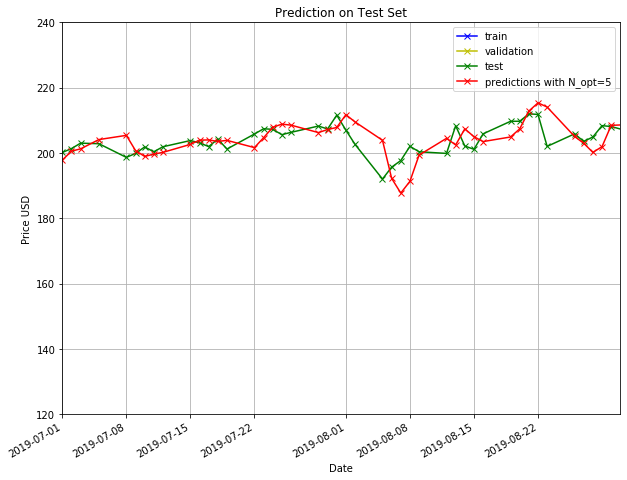

In [323]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # 

ax = train.plot(x='Date', y='Adj_Close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Adj_Close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_Close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_xlim([date(2019, 7, 1), date(2019, 8, 31)])
ax.set_ylim([120, 240])
ax.set_title('Prediction on Test Set')
plt.savefig("./images/Testset.png")

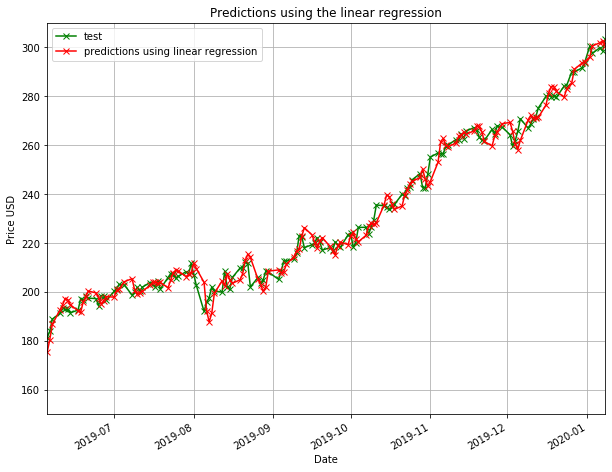

In [324]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 

ax = test.plot(x='Date', y='Adj_Close', style='gx-', grid=True)
ax = test.plot(x='Date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("Date")
ax.set_ylabel("Price USD")
ax.set_xlim([date(2019, 6, 5), date(2020, 1, 8)])
ax.set_ylim([150, 310])
ax.set_title('Predictions using the linear regression')
plt.savefig("./images/Prediction.png")

# Findings
The lowest RMSE is 3.905 On the validation set. It came when using N=1, ie. using value on day t-1 to predict value on day t.

The hightest R2 is 0.954 on the validation set. It came when using N=1, ie. using value on day t-1 to predict value on day t.

We will use N_opt=5 because our goal is to use linear regression

The RMSE is 3.953 on the test set using N_opt=5.

The MAPE is 1.370% on the test set using N_opt=5.

The R2 is 0.985 on the test set using N_opt=5.